In [1]:
# Add anna to the path
import os
import sys
module_path = os.path.abspath(os.path.join('../../../anna'))
if module_path not in sys.path:
    sys.path.append(module_path)

DATA_DIR = "../../../data"

In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import anna.data.dataset.reuters21578 as reuters
import anna.model.premade as models
import anna.summary.extract as summary
import anna.summary.plots as plots

tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [3]:
# Load data
train_docs, test_docs, unused_docs, labels = reuters.fetch_and_parse(DATA_DIR)

# Standard Reuters Config
val_size = 777
epochs = 40
shuffle = 10000
folder_name = "model-embeddings"

In [4]:
for emb in ["glove", "fasttext", "none"]:
    # Create default trainer
    model = models.AVGxBR(DATA_DIR, labels,
                          name=emb,
                          folder_name=folder_name,
                          pretrained_embeddings="fasttext" if emb == "none" else emb,
                          voc_size=1 if emb == "none" else 100000,
                          oov_size=100000 if emb == "none" else 0)

    # Train and evaluate
    print("Model: {}, Embeddings: {}".format(model, emb))
    model.train(train_docs, test_docs,
                val_size=val_size, epochs=epochs, shuffle=shuffle)

    # Delete to save memory
    del model

In [5]:
# Evaluate non-trainable embeddings
model = models.AVGxBR(DATA_DIR, labels,
                      name="non-trainable",
                      folder_name=folder_name,
                      trainable_embeddings=False,
                      voc_size=100000,
                      oov_size=0)

# Train and evaluate
print("Model: {}, Embeddings: non-trainable glove".format(model))
model.train(train_docs, test_docs,
            val_size=val_size, epochs=epochs, shuffle=shuffle)

# Delete to save memory
del model

In [6]:
model_path = os.path.join(DATA_DIR, folder_name)
metrics_path = os.path.join(model_path, "metrics.json")

In [7]:
# Load from tfrecord event files
metrics = summary.parse_all(model_path)
with open(metrics_path, "w") as f:
    json.dump(metrics, f)

In [8]:
# Load from json serialized metrics
#with open(metrics_path, "r") as f:
#    metrics = json.load(f)

In [9]:
num_epochs = min([len(m["val"]["perf/accuracy"]) for m in metrics.values()])

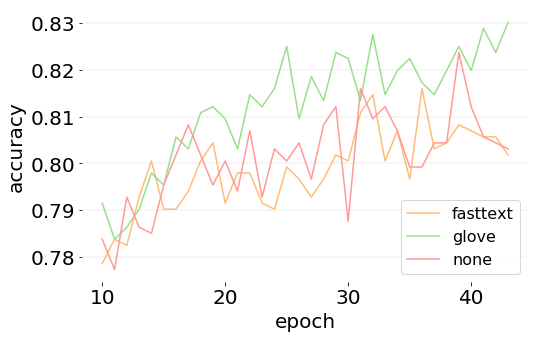

In [10]:
remove_first = 10

x = range(num_epochs)[remove_first:]

pre, ax = plots.subplots(figsize=[8, 5], xlabel="epoch")

i = 3
for name, metric in sorted(metrics.items()):
    if name == "non-trainable":
        continue
    y = metric["val"]["perf/accuracy"][remove_first:num_epochs]
    y = [m[1] for m in y]
    plots.plot(ax, x, y, color=i, label=name)
    i += 2

ax.set_ylabel("accuracy")
ax.legend(loc=4, fontsize=16)

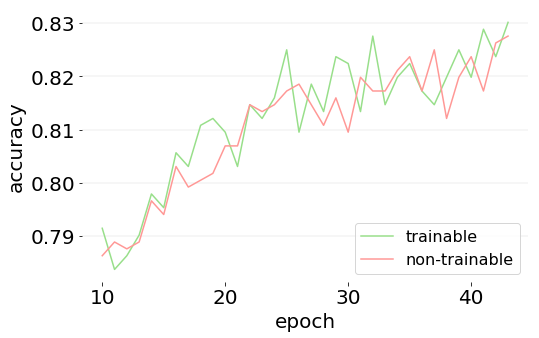

In [11]:
remove_first = 10

x = range(num_epochs)[remove_first:]

pre, ax = plots.subplots(figsize=[8, 5], xlabel="epoch")

i = 5
for name, metric in [("trainable", metrics["glove"]), ("non-trainable", metrics["non-trainable"])]:
    y = metric["val"]["perf/accuracy"][remove_first:num_epochs]
    y = [m[1] for m in y]
    plots.plot(ax, x, y, color=i, label=name)
    i += 2

ax.set_ylabel("accuracy")
ax.legend(loc=4, fontsize=16)